## Import necessary Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date, datetime, timedelta

import os

## Object of Portfolios and benchmarking ETF

In [2]:
class EquitiesPF():

    def __init__(self, benchmark, symbollist, etf_path, symbol_path, rf, startdate, enddate):
        self.benchmark = benchmark     # Benchmark equity index (e.g. S&P 500 ETF such as SPY or VOO)
        self.symbollist = symbollist   # List of all equity symbols to be considered
        self.etf_path = self.join_path(etf_path)   # ETF data path
        self.symbol_path = self.join_path(symbol_path)  
        self.startdate = startdate     # Start of buy-and-hold period
        self.enddate = enddate         # End of buy-and-hold period
        self.data_dict = self.get_data_dict()   # Dictionary with each equity symbol corresponding to its historical data
        self.rf = rf  # risk-free rate
        
    def join_path(self, *args):
        """Convenient function to trace local data folders."""
        yahoo_path = os.path.join('D:\\', 'Trading', 'Data', 'eod_yahoofinance')
        return os.path.join(yahoo_path, *args)
    
    def get_data_dict(self):
        """Create dictionary matching each symbol with historical prices dataframe."""
        price_dict = dict()
        # Set the data columns of each Yahoo Finance Dataframe
        columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        # Collect the index ETF data into the data dict
        df_benchmark = pd.read_csv(self.join_path(self.etf_path, self.benchmark + '.csv'), 
                               header=0, index_col='date', parse_dates=True)
        df_benchmark = df_benchmark.loc[self.startdate:self.enddate]
        df_benchmark.columns = columns
        price_dict[self.benchmark] = df_benchmark
        
        # Collect each symbol data into the data dict
        for symbol in self.symbollist:
            df = pd.read_csv(self.join_path(self.symbol_path, symbol + '.csv'), 
                             header=0, index_col='date', parse_dates=True)
            df.fillna(method='ffill', inplace=True)           
            df = df.loc[self.startdate:self.enddate]
            df.columns = columns
            price_dict[symbol] = df
        
        return price_dict
    
    def get_normed_price(self):
        """Set the price of each asset to be 1.00 at startdate and normalize the historical prices."""
        df_normed_benchmark = self.data_dict[self.benchmark].loc[:, ['Close']] / self.data_dict[self.benchmark].loc[:, 'Close'][0]
        df_normed_benchmark.columns = [self.benchmark]
        df_normed_symbols = pd.DataFrame(columns=self.symbollist)
        for symbol in self.symbollist:
            df_normed_symbols[symbol] = self.data_dict[symbol].loc[:, 'Close'] / self.data_dict[symbol].loc[:, 'Close'][0]
        
        return df_normed_benchmark, df_normed_symbols
    
    def pf_weight(self, weight):
        """Get the daily percentage return of each symbol, the portfolio and the benchmark index ETF."""
        assert weight.min() >= 0, 'Input weight vector has negative weight!'
        assert len(weight) == len(self.symbollist), 'Length of weight vector does NOT match!'
        df_normed_benchmark, df_normed_pf = self.get_normed_price()
        df_normed_pf['Portfolio'] = df_normed_pf.mul(weight, axis=1).sum(axis=1)
        df_normed_pf['Benchmark'] = df_normed_benchmark

        # Percentage return for each symbol and the weighted portfolio
        df_pct_pf = df_normed_pf.pct_change()

        return df_normed_pf, df_pct_pf
    
    def pf_cov(self, weight):
        """Compute the asset corrleation & covariance and also with the portfolio and benchmark."""
        df_normed_df, df_pct_pf = self.pf_weight(weight)
        cov_symbols = df_pct_pf.cov()
        corr_symbols = df_pct_pf.corr()
        return cov_symbols, corr_symbols
    
    def pf_perform_KPI(self, weight):
        """Get the performance KPI from the time series of percentage or logarithmic daily return."""
        df_normed_pf, df_pct_pf = self.pf_weight(weight)
        cov_symbols, corr_symbols = self.pf_cov(weight)
        df_log_pf = np.log(df_pct_pf.add(1))
        df_kpi = pd.DataFrame(columns=df_log_pf.columns)
        row_label = pd.Series(['mean_return', 'sigma', 'sharpe_ratio', 'MDD', 'beta'])
        for asset in df_kpi.columns:
            mean_return = df_log_pf[asset].mean() * 252 - self.rf  # Mean annualized return minus risk-free rate
            sd_return = df_log_pf[asset].std() * np.sqrt(252) # Annualized volatility
            df_kpi[asset] = [mean_return, sd_return, 
                             mean_return / sd_return,   # Sharpe Ratio
                             (df_normed_pf[asset] / df_normed_pf[asset].cummax()).min() - 1, # MDD
                             cov_symbols.loc[asset, 'Benchmark'] / cov_symbols.loc['Benchmark', 'Benchmark'] ]
        df_kpi.set_index(row_label, inplace=True)
                
        return df_kpi

### Object of Sector ETF Portfolio

In [7]:
# US Sector ETF list 

sectorlist = ['QQQ', # Technology Index ETF
              'XLP', # Consumer Staples Sector ETF
              'XLV', # Health Care ETF
              'XLY', # Consumer Discretionary ETF
              'AGG', # Aggregate investment-grade bond ETF
              'TLT', # 20-Year Treasury Bond ETF
             ]
              
benchmark = 'SPY'         # S&P 500 ETF
etf_path = 'ETF_adjusted' # Use dividend-adjusted data, assuming dividend reinvestment
rf = 0.02
startdate = '2007-01-02'
enddate = '2019-06-30'

USetf = EquitiesPF(benchmark, sectorlist, etf_path, etf_path, rf, startdate, enddate) # Object of ETF portfolios

# The normed index of each ETF (with prices on 2-Jan-2011 set as 1.0000)
df_spy, df_sector = USetf.get_normed_price()
df_sector.head(10)



,QQQ,XLP,XLV,XLY,AGG,TLT
date,,,,,,
2007-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2007-01-04,1.018964,1.001521,1.011344,0.999741,1.002102,1.006064
2007-01-05,1.014107,0.994294,1.005672,0.992991,1.001402,1.001685
2007-01-08,1.014801,0.995816,1.006866,0.994548,1.002002,1.003481
2007-01-09,1.019889,0.998098,1.005672,1.000000,1.002002,1.003481
2007-01-10,1.031914,1.002282,1.007463,1.005192,1.000901,0.998990
2007-01-11,1.042553,1.009890,1.018508,1.016355,0.998999,0.993151
2007-01-12,1.047872,1.008368,1.023283,1.019211,0.997598,0.988548
2007-01-16,1.047178,1.009129,1.025672,1.022846,0.998899,0.990681


In [8]:
# Equal Weight Portfolio
eqweight = np.repeat(1/len(sectorlist), len(sectorlist))
df_pct_sector = USetf.pf_weight(eqweight)

# Buy-and-hold Performance over past 12 years
df_kpi = USetf.pf_perform_KPI(eqweight)
df_kpi

,QQQ,XLP,XLV,XLY,AGG,TLT,Portfolio,Benchmark
mean_return,0.106322,0.070290,0.078970,0.085385,0.019765,0.044355,0.072205,0.058913
sigma,0.209032,0.136706,0.169125,0.215216,0.048687,0.142103,0.099972,0.195170
sharpe_ratio,0.508639,0.514174,0.466932,0.396742,0.405959,0.312132,0.722248,0.301853
MDD,-0.534040,-0.323876,-0.391703,-0.590476,-0.128353,-0.265854,-0.251867,-0.551894
beta,0.982971,0.548534,0.712136,0.991142,-0.031566,-0.316271,0.445719,1.000000


### Correlation & Covariance of returns

- Notice that TLT & GLD has negative beta and hence negative correlation with SPY 
- Utilities Sector has least beta among all sector ETFs

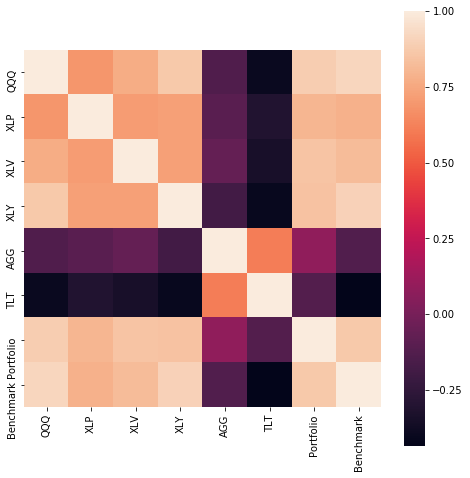

In [9]:
import seaborn as sns

cov_pf, corr_pf = USetf.pf_cov(eqweight)

# Using Heatmap to illustrate corrleation matrix 
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr_pf, square=True, ax=ax)

In [10]:
corr_pf

,QQQ,XLP,XLV,XLY,AGG,TLT,Portfolio,Benchmark
QQQ,1.000000,0.689963,0.765452,0.868162,-0.134803,-0.395811,0.882889,0.918046
XLP,0.689963,1.000000,0.713772,0.723552,-0.101404,-0.306020,0.798583,0.784152
XLV,0.765452,0.713772,1.000000,0.723534,-0.063252,-0.341725,0.852779,0.822625
XLY,0.868162,0.723552,0.723534,1.000000,-0.186835,-0.402113,0.846709,0.900597
AGG,-0.134803,-0.101404,-0.063252,-0.186835,1.000000,0.608358,0.086551,-0.127139
TLT,-0.395811,-0.306020,-0.341725,-0.402113,0.608358,1.000000,-0.122163,-0.434384
Portfolio,0.882889,0.798583,0.852779,0.846709,0.086551,-0.122163,1.000000,0.870594
Benchmark,0.918046,0.784152,0.822625,0.900597,-0.127139,-0.434384,0.870594,1.000000


## Object of Portfolio Optimizer 

- Use uniform distribution to generate weights 
- Adopt "Max entropy principle" based on assumption that we have no significant prior knowledge 

In [14]:
class PFOptimizer(EquitiesPF):
    
    def __init__(self, benchmark, symbollist, etf_path, symbol_path, rf, startdate, enddate, rand_size):
        super().__init__(benchmark, symbollist, etf_path, symbol_path, rf, startdate, enddate)
        self.rand_size = rand_size                  # Number of simulations
        self.rand_weight = self.get_random_weight() # Dataframe consisting of each random weight
        self.normed_benchmark, self.normed_symbols = super().get_normed_price() 
        
    def get_random_weight(self):
        """Generate random weights from uniform distribution and store them into a dataframe."""
        df_weight = pd.DataFrame(columns=self.symbollist)
        for symbol in self.symbollist:
            df_weight[symbol] = np.random.uniform(size=self.rand_size)
        df_weight = df_weight.div(df_weight.sum(axis=1), axis=0)
        
        return df_weight
        
    def randweight_kpi(self, start, end):
        """Compute KPI's such as mean return, sigma for each randomized portfilio."""
        # Create empty dataframe with the desired KPI as column names
        kpi_columns = ['mean%', 'sigma%', 'sharpe', 'beta']
        df_kpi = pd.DataFrame(columns=kpi_columns)
        
        if (start == self.startdate) and (end == self.enddate):
            period_benchmark = self.normed_benchmark
            period_symbols = self.normed_symbols
        else:
            period_benchmark = self.normed_benchmark[start:end]
            period_benchmark = period_benchmark / period_benchmark.iloc[0, :]
            period_symbols = self.normed_symbols[start:end]
            period_symbols = period_symbols / period_symbols.iloc[0, :]
        
        benchmark_return = np.log(period_benchmark.pct_change() + 1)
        
        # For loop to compute the KPI
        for num in range(self.rand_size):
            weight = self.rand_weight.iloc[num, :]
            df_portfolio = period_symbols.mul(weight, axis=1).sum(axis=1)
            log_return = np.log(df_portfolio.pct_change() + 1)
            
            log_mean = 100 * (log_return.mean() * 252 - self.rf)     # Annualized log return
            log_sd = 100 * log_return.std() * np.sqrt(252)           # Average daily SD
            sharpe = log_mean / log_sd                               # Sharpe Ratio
            
            # Calcuation of beta (ratio of covariance over benchmark's variance)
            cov_random = pd.concat([pd.DataFrame(log_return, columns=['portfolio']), benchmark_return], axis=1).cov()
            beta = cov_random.iloc[0, 1] / cov_random.iloc[1, 1]    # beta
            
            # Maximum Drawdown 
            mdd = (df_portfolio / df_portfolio.cummax()).min() - 1          
                      
            df_kpi = df_kpi.append({'mean%': log_mean, 'sigma%': log_sd, 'sharpe': sharpe, 'beta': beta, 'mdd': mdd}, 
                                   ignore_index=True)
            
        df_kpi = pd.concat([self.rand_weight, df_kpi], axis=1)    
        
        return df_kpi
            
    def train_test_split(self, train_start, train_end, test_start, test_end):
        """Split the dataset into training set and test set, with normed prices in each of two datasets."""
        train_kpi = self.randweight_kpi(train_start, train_end)
        test_kpi = self.randweight_kpi(test_start, test_end)
        
        return train_kpi, test_kpi
    
    

## Simulate 2500 portfolios

In [15]:
# Start time count for simulations
from time import time
start_time = time()

# Initialize ETF portfolio Optimizer
rf = 0.02
size = 2500
startdate = '2007-01-02'
enddate = '2019-06-30'
Etfopt = PFOptimizer(benchmark, sectorlist, etf_path, etf_path, rf=rf, rand_size=size, startdate=startdate, enddate=enddate)

# Random Weights
etf_weight = Etfopt.rand_weight  

# KPI corresponding to each portfolio
etf_kpi = Etfopt.randweight_kpi(startdate, enddate)

print('Mean Sharpe: ', etf_kpi['sharpe'].mean())
print('Max Sharpe: ',  etf_kpi['sharpe'].max())
print('Mean CAGR: ', etf_kpi['mean%'].mean())
print('Max CAGR: ', etf_kpi['mean%'].max())
print('Mean Sigma: ' , etf_kpi['sigma%'].mean())
print('Min Sigma: ' , etf_kpi['sigma%'].min())
print('Average beta: ', etf_kpi['beta'].mean())
print('Average MDD: ', etf_kpi['mdd'].mean())

# Check time elapsed
print('\nTime elapsed: ', time() - start_time)

Mean Sharpe:  0.7070303996883174
Max Sharpe:  0.8555901138491011
Mean CAGR:  7.202318890990404
Max CAGR:  9.675846062514184
Mean Sigma:  10.362726134264832
Min Sigma:  5.855069946393253
Average beta:  0.44920258381911116
Average MDD:  -0.2579043090088675

Time elapsed:  14.88251280784607


### Sorting with Sharpe ratios, mean return & volatility

In [16]:
# Portfolio with max sharpe
maxsharpe_row = etf_kpi['sharpe'].idxmax()
maxsharpe_df = etf_weight.iloc[[maxsharpe_row], :]

# Portfolio with max return
maxreturn_row = etf_kpi['mean%'].idxmax()
maxreturn_df = etf_weight.iloc[[maxreturn_row], :]

# Portfolio with min volatility
minvol_row = etf_kpi['sigma%'].idxmin()
minvol_df = etf_weight.iloc[[minvol_row], :]

# Joining the three objectives
df_optpf = pd.concat([maxsharpe_df, maxreturn_df, minvol_df], axis=0)
df_optpf.index = ['max_sharpe', 'max_return', 'min_vol']
df_optpf

,QQQ,XLP,XLV,XLY,AGG,TLT
max_sharpe,0.096462,0.186710,0.046064,0.079830,0.308629,0.282305
max_return,0.699338,0.045446,0.036994,0.135359,0.078573,0.004290
min_vol,0.048044,0.269599,0.016779,0.009176,0.474425,0.181977


### Average weights of top 25 Sharpe-ratio portfolios (with pie chart)

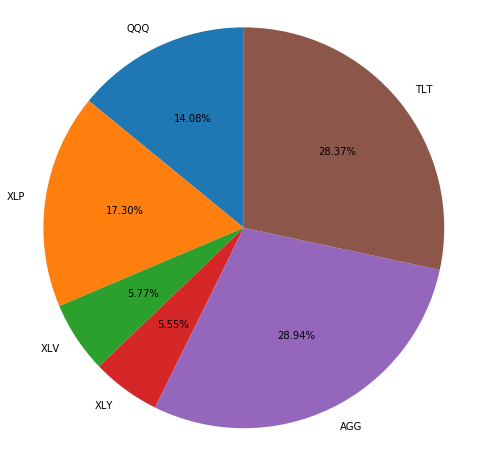

In [17]:
# Sort the portfolios by Sharpe ratio (descending order)
df_sort_sharpe = etf_kpi.sort_values(['sharpe', 'mean%'], ascending=False)
df_sort_sharpe.reset_index(inplace=True)
df_sort_sharpe.drop('index', axis=1, inplace=True)

# Average weights & Sharpe ratio of the top 1% portfolios
top_sharpe = pd.DataFrame(df_sort_sharpe.head(size//100).mean()).transpose()

# Piechart labels by the ETF symbol list
labels = USetf.symbollist
pct = top_sharpe.loc[0, USetf.symbollist]

# Constructing Pie Chart
fig, ax = plt.subplots(figsize=(8,8))
ax.pie(pct, labels=labels, autopct='%1.2f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()


In [18]:
# Average KPI for the top 25 Sharpe-ratio Portfolios

top_sharpe.loc[:, ['mean%', 'sigma%', 'sharpe', 'beta', 'mdd']]

,mean%,sigma%,sharpe,beta,mdd
0,6.033582,7.115008,0.84805,0.211657,-0.140628


### Average weights of top 25 Return portfolios

-  Expect heavier weights of best-growth sectors such as health care and technologies

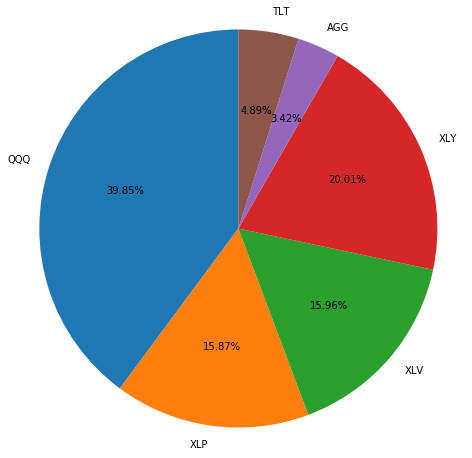

In [19]:
# Average weights & Sharpe ratio of the top 25 return portfolios
df_sort_return = etf_kpi.sort_values(['mean%', 'sharpe'], ascending=False)
df_sort_return.reset_index(inplace=True)
df_sort_return.drop('index', axis=1, inplace=True)

top_return = pd.DataFrame(df_sort_return.head(size//100).mean()).transpose()
pct = top_return.loc[0, USetf.symbollist]

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(pct, labels=labels, autopct='%1.2f%%', shadow=False, startangle=90)
ax.axis('equal')

plt.show()

In [20]:
# Average KPI for the top 25 return Portfolios

top_return.loc[:, ['mean%', 'sigma%', 'sharpe', 'beta', 'mdd']]

,mean%,sigma%,sharpe,beta,mdd
0,8.855773,15.677322,0.566012,0.754675,-0.421623


### Average weights of top 25 low-volatility portfolios

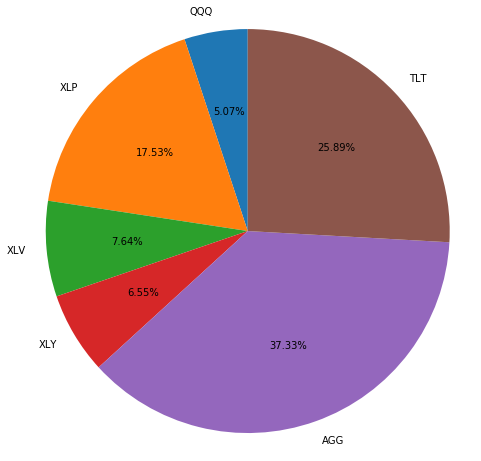

In [21]:
# Average weights & Sharpe ratio of the bottom 1% volatility portfolios

df_sort_sigma = etf_kpi.sort_values(['sigma%'], ascending=True)
df_sort_sigma.reset_index(inplace=True)
df_sort_sigma.drop('index', axis=1, inplace=True)

min_vol = pd.DataFrame(df_sort_sigma.head(size//100).mean()).transpose()
pct = min_vol.loc[0, USetf.symbollist]

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(pct, labels=labels, autopct='%1.2f%%', shadow=False, startangle=90)
ax.axis('equal')

plt.show()

In [22]:
# Average KPI for the top 25 low-vol Portfolios

min_vol.loc[:, ['mean%', 'sigma%', 'sharpe', 'beta', 'mdd']]

,mean%,sigma%,sharpe,beta,mdd
0,5.285499,6.422756,0.822708,0.153125,-0.127507


### Scatter Plot & Optimal Portfolios

D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


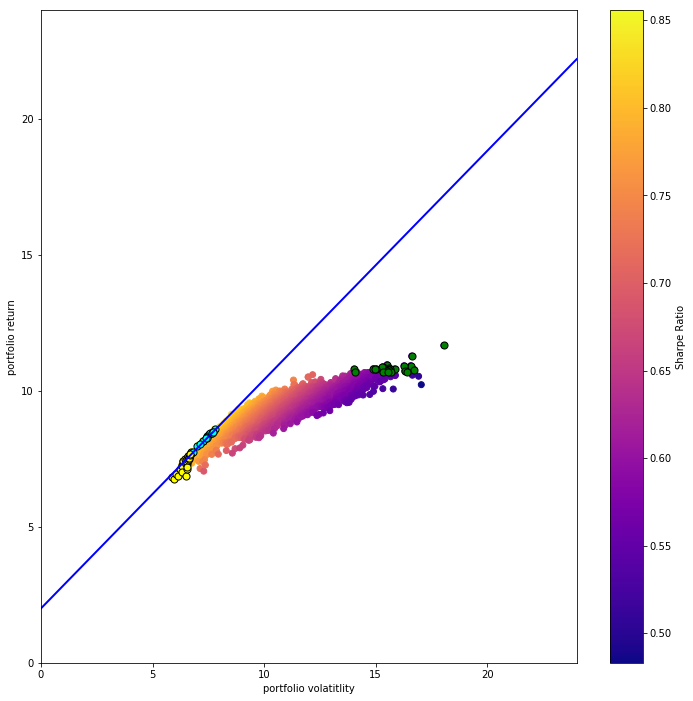

In [23]:
# Scatter plot of all (sigma, return)-tuple of the 10000 portfolios 
plt.figure(figsize=(12,12))
fig = plt.scatter(df_sort_sharpe['sigma%'], df_sort_sharpe['mean%'] + 100 * rf, c=df_sort_sharpe['sharpe'], cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('portfolio volatitlity')
plt.ylabel('portfolio return')

# Add cyan dots for top 25 Sharpe ratio
top1 = plt.scatter(df_sort_sharpe.head(size//100)['sigma%'], df_sort_sharpe.head(size//100)['mean%'] + 100 * rf, c='cyan', s=50, edgecolors='black')

# Add green dots for top 25 Return
top2 = plt.scatter(df_sort_return.head(size//100)['sigma%'], df_sort_return.head(size//100)['mean%'] + 100 * rf, c='green', s=50, edgecolors='black')

# Add yellow dots for top 25 low-vol
top3 = plt.scatter(df_sort_sigma.head(size//100)['sigma%'], df_sort_sigma.head(size//100)['mean%'] + 100 * rf, c='yellow', s=50, edgecolors='black')

# Add straight line of optimal portfolios
xline = np.linspace(0, 24.0, 500)
yline = df_sort_sharpe['sharpe'][size//100] * xline + 100 * rf
plt.plot(xline, yline, 'b-', linewidth=2)

# Set annualized return range from 0 to 24%
plt.ylim(ymin=0)
plt.ylim(ymax=24)

# Set sigma range from 0 to 16%
plt.xlim(xmin=0)
plt.xlim(xmax=24)
plt.show()

- However the above diagram is NOT a reasonable modelling of forward testing
- Train-test-split is necessary

## Train-test-split on asset weights

- Split the dataset into two equal halves
- Find the top 1% sharpe-ratio portfolios on training set (2007-2012)
- Verify the respective (sigma, return)-tuple on test set (2013-2018)


D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


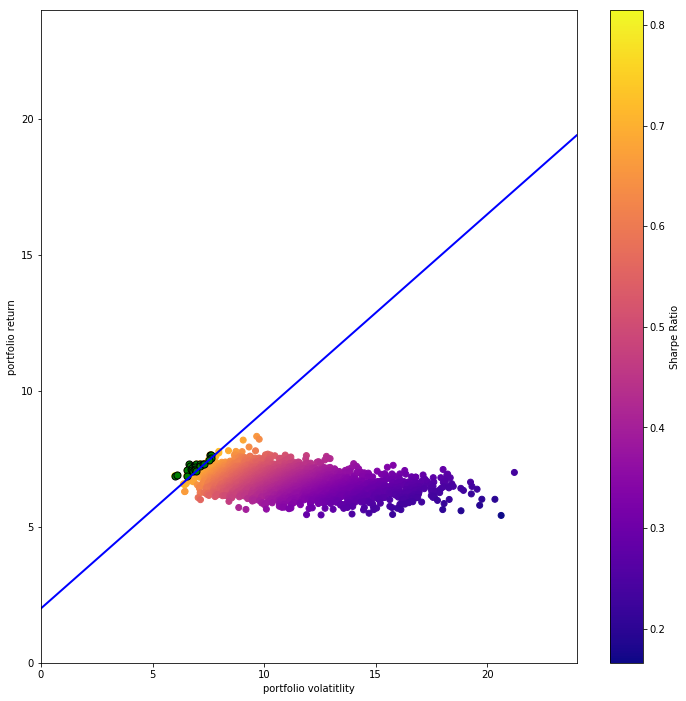

In [24]:
# Split the dataset by the timestamp 2012-12-31
# train_KPI:  2007-2012
# test_KPI:   2013-2018
train_end = '2013-01-01'
train_kpi, test_kpi = Etfopt.train_test_split(startdate, train_end, train_end, enddate)

# Sort with descending Sharpe ratio and scatter plots 
train_sort_sharpe = train_kpi.sort_values(['sharpe', 'mean%'], ascending=False)
train_sort_sharpe.reset_index(inplace=True)

plt.figure(figsize=(12,12))
fig = plt.scatter(train_sort_sharpe['sigma%'], train_sort_sharpe['mean%'] + 100 * rf, c=train_sort_sharpe['sharpe'], cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('portfolio volatitlity')
plt.ylabel('portfolio return')

# Add green dots for top 1% Sharpe ratio
top = plt.scatter(train_sort_sharpe.head(size//100)['sigma%'], train_sort_sharpe.head(size//100)['mean%'] + 100 * rf, c='green', s=50, edgecolors='black')

# Add straight line of optimal portfolio
xline = np.linspace(0, 24.0, 500)
yline = train_sort_sharpe['sharpe'][size//100] * xline + 100 * rf
plt.plot(xline, yline, 'b-', linewidth=2)

# Set annualized return range from 0 to 24%
plt.ylim(ymin=0)
plt.ylim(ymax=24)

# Set sigma range from 0 to 24%
plt.xlim(xmin=0)
plt.xlim(xmax=24)
plt.show()


In [25]:
train_sort_sharpe.head()

,index,QQQ,XLP,XLV,XLY,AGG,TLT,mean%,sigma%,sharpe,beta,mdd
0,1345,0.048044,0.269599,0.016779,0.009176,0.474425,0.181977,4.886326,5.999399,0.814469,0.103702,-0.127609
1,1275,0.015560,0.304586,0.026174,0.017214,0.446818,0.189648,4.902060,6.097969,0.803884,0.103468,-0.125992
2,1995,0.050729,0.323767,0.029437,0.000934,0.319830,0.275302,5.297782,6.650579,0.796590,0.104269,-0.119141
3,740,0.080053,0.253950,0.003157,0.053038,0.324669,0.285132,5.254503,6.696658,0.784646,0.111183,-0.121252
4,1819,0.088889,0.219601,0.070046,0.011565,0.353258,0.256642,5.090205,6.557872,0.776198,0.118521,-0.126325


In [26]:
test_kpi.head()

,QQQ,XLP,XLV,XLY,AGG,TLT,mean%,sigma%,sharpe,beta,mdd
0,0.183339,0.215651,0.105339,0.155847,0.291988,0.047835,9.086311,9.459243,0.960575,0.699158,-0.139764
1,0.199761,0.281030,0.222334,0.098331,0.113915,0.084628,10.205700,10.618660,0.961110,0.781460,-0.146044
2,0.308650,0.177088,0.085784,0.097656,0.303279,0.027544,9.672899,10.165441,0.951547,0.752081,-0.152899
3,0.266795,0.112138,0.239804,0.141410,0.187831,0.052022,10.745020,11.174204,0.961591,0.829519,-0.161799
4,0.173541,0.185477,0.159428,0.159621,0.116394,0.205539,9.541835,9.522357,1.002046,0.686219,-0.138815


D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


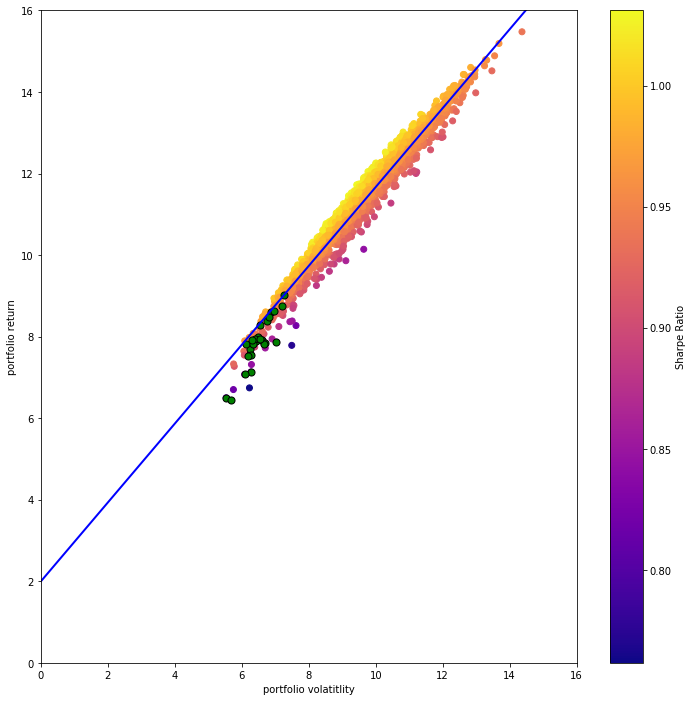

In [28]:
# Apply the top 1% sharpe in training set to test set 

top_index = train_sort_sharpe.loc[0:size//100, 'index']

plt.figure(figsize=(12,12))
fig = plt.scatter(test_kpi['sigma%'], test_kpi['mean%'] + 100 * rf, c=test_kpi['sharpe'], cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('portfolio volatitlity')
plt.ylabel('portfolio return')

# Add red dots for top 1% Sharpe ratio
top = plt.scatter(test_kpi.loc[top_index, 'sigma%'], test_kpi.loc[top_index, 'mean%'] + 100 * rf, c='green', s=50, edgecolors='black')

# Add straight line of training-set-99.5%ile portfolio
xline = np.linspace(0, 16.0, 500)
yline = test_kpi.loc[top_index,'sharpe'].max() * xline + 100 * rf
plt.plot(xline, yline, 'b-', linewidth=2)

# Set annualized return range from 0 to 16%
plt.ylim(ymin=0)
plt.ylim(ymax=16)

# Set sigma range from 0 to 16%
plt.xlim(xmin=0)
plt.xlim(xmax=16)
plt.show()

### KPI for training set and test set

- Expect top 25 Sharpe in training set performs worse in test set
- Expect lower Sharpe in test set versus training set due to 2015 & 2018 huge correction 

In [29]:
# KPI for training set

top_train = pd.DataFrame(train_sort_sharpe.head(size//100).mean()).transpose()
top_train.loc[:, ['mean%', 'sigma%', 'sharpe', 'beta', 'mdd']]

,mean%,sigma%,sharpe,beta,mdd
0,5.220295,6.919147,0.755582,0.115207,-0.126814


In [30]:
# Mean Performance in test set

top_apply_test = pd.DataFrame(test_kpi.loc[top_index].mean()).transpose()
top_apply_test.loc[:, ['mean%', 'sigma%', 'sharpe', 'beta', 'mdd']]

,mean%,sigma%,sharpe,beta,mdd
0,5.863579,6.479845,0.903079,0.343472,-0.085745


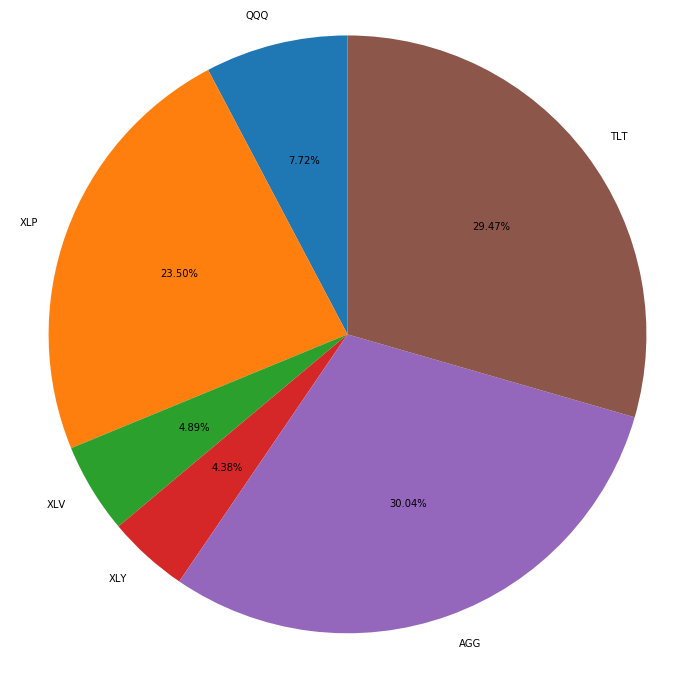

In [31]:
# Mean allocation for top 1% sharpe in training set

sector_list = USetf.symbollist

top_train = pd.DataFrame(train_sort_sharpe.head(size//100).mean()).transpose()
top_train_allocate = top_train.loc[0, sector_list]

fig, ax = plt.subplots(figsize=(12,12))
ax.pie(top_train_allocate, labels=sector_list, autopct='%1.2f%%', shadow=False, startangle=90)
ax.axis('equal')

plt.show()


## Train-test-split post 2008




D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


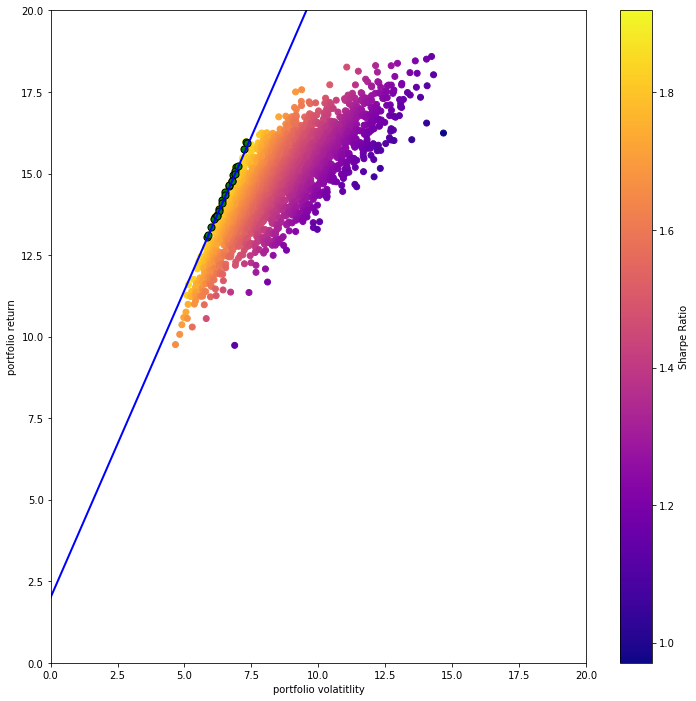

In [32]:
# Split the dataset by the timestamp 2014-12-31
# train_KPI:  2011-2014
# test_KPI:   2015-2019
train_start = '2011-01-01'
train_end = '2015-01-01'
train_kpi, test_kpi = Etfopt.train_test_split(train_start, train_end, train_end, enddate)

# Sort with descending Sharpe ratio and scatter plots 
train_sort_sharpe = train_kpi.sort_values(['sharpe', 'mean%'], ascending=False)
train_sort_sharpe.reset_index(inplace=True)

plt.figure(figsize=(12,12))
fig = plt.scatter(train_sort_sharpe['sigma%'], train_sort_sharpe['mean%'] + 100 * rf, c=train_sort_sharpe['sharpe'], cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('portfolio volatitlity')
plt.ylabel('portfolio return')

# Add green dots for top 1% Sharpe ratio
top = plt.scatter(train_sort_sharpe.head(size//100)['sigma%'], train_sort_sharpe.head(size//100)['mean%'] + 100 * rf, c='green', s=50, edgecolors='black')

# Add straight line of optimal portfolio
xline = np.linspace(0, 20.0, 500)
yline = train_sort_sharpe['sharpe'][size//100] * xline + 100 * rf
plt.plot(xline, yline, 'b-', linewidth=2)

# Set annualized return range from 0 to 20%
plt.ylim(ymin=0)
plt.ylim(ymax=20)

# Set sigma range from 0 to 20%
plt.xlim(xmin=0)
plt.xlim(xmax=20)
plt.show()


D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


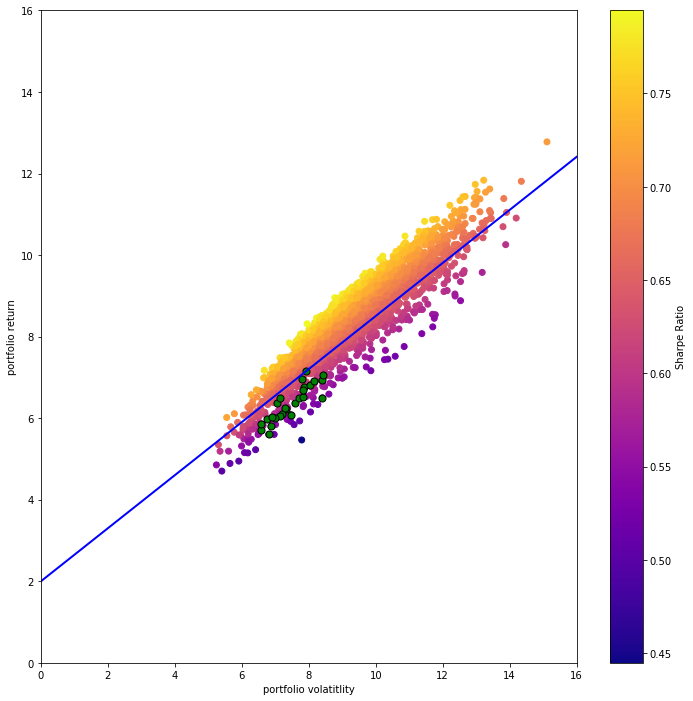

In [33]:
# Apply the top 1% sharpe in training set to test set 

top_index = train_sort_sharpe.loc[0:size//100, 'index']

plt.figure(figsize=(12,12))
fig = plt.scatter(test_kpi['sigma%'], test_kpi['mean%'] + 100 * rf, c=test_kpi['sharpe'], cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('portfolio volatitlity')
plt.ylabel('portfolio return')

# Add red dots for top 1% Sharpe ratio
top = plt.scatter(test_kpi.loc[top_index, 'sigma%'], test_kpi.loc[top_index, 'mean%'] + 100 * rf, c='green', s=50, edgecolors='black')

# Add straight line of training-set-99.5%ile portfolio
xline = np.linspace(0, 16.0, 500)
yline = test_kpi.loc[top_index,'sharpe'].max() * xline + 100 * rf
plt.plot(xline, yline, 'b-', linewidth=2)

# Set annualized return range from 0 to 16%
plt.ylim(ymin=0)
plt.ylim(ymax=16)

# Set sigma range from 0 to 16%
plt.xlim(xmin=0)
plt.xlim(xmax=16)
plt.show()

In [34]:
# KPI for training set

top_train = pd.DataFrame(train_sort_sharpe.head(size//100).mean()).transpose()
top_train.loc[:, ['mean%', 'sigma%', 'sharpe', 'beta', 'mdd']]

,mean%,sigma%,sharpe,beta,mdd
0,12.439014,6.558365,1.896467,0.23298,-0.054703


In [35]:
# Mean Performance in test set

top_apply_test = pd.DataFrame(test_kpi.loc[top_index].mean()).transpose()
top_apply_test.loc[:, ['mean%', 'sigma%', 'sharpe', 'beta', 'mdd']]

,mean%,sigma%,sharpe,beta,mdd
0,4.374627,7.46358,0.585566,0.401218,-0.090842


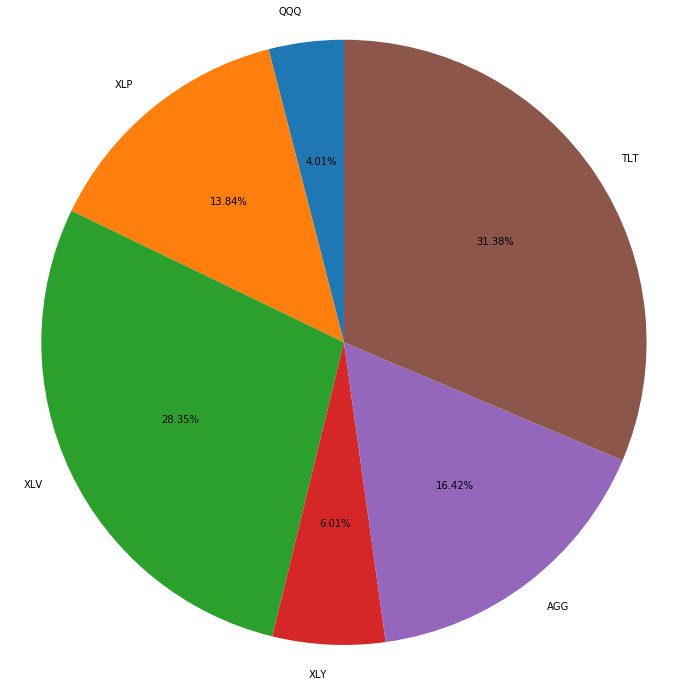

In [36]:
# Mean allocation for top 1% sharpe in training set

sector_list = USetf.symbollist

top_train = pd.DataFrame(train_sort_sharpe.head(size//100).mean()).transpose()
top_train_allocate = top_train.loc[0, sector_list]

fig, ax = plt.subplots(figsize=(12,12))
ax.pie(top_train_allocate, labels=sector_list, autopct='%1.2f%%', shadow=False, startangle=90)
ax.axis('equal')

plt.show()